In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from PIL import Image

import torch
from torchvision.datasets import LFWPeople, LFWPairs
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from torch.nn import Parameter

In [10]:
# Parametrs
batch = 20
path = "ваш путь"
torch.manual_seed(20)

# если обучение происходит на cpu (чего я крайне не советую :) ), замените
# cuda:0 на cpu
device = torch.device('cuda:0')

In [11]:
# подготовка датасета для DataLoader
class PeopleTrainDataset(Dataset):
    def __init__(self, path):
        if not os.path.exists(f"{path}/lfw-py"):
            images = LFWPeople(path, split="train", download=True)
        else:
            images = LFWPeople(path, split="train")
        # далее идёт цикл для переобозначения лэйблов, так как
        # в исходном сете они идут не по порядку
        ind = torch.arange(4038)
        num = 0
        j = 0
        self.new_images = []
        for i in tqdm(images):
          if num == i[1]:
            img = i[0], ind[j]
          else:
            j+=1
            img = i[0], ind[j]
          num = i[1]
          self.new_images.append(img)

    def __len__(self):
        return len(self.new_images)

    def __getitem__(self, idx):
        X, target = self.new_images[idx]
        transform=transforms.ToTensor()
        X = transform(X)
        return X, target


train_dataset =  PeopleTrainDataset(path)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

100%|██████████| 9525/9525 [00:29<00:00, 318.73it/s]


In [12]:
class CosFace(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.40):
        super().__init__()
        self.s = s
        self.m = m
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        # cos(theta) & phi(theta)
        cosine = nn.functional.linear(nn.functional.normalize(input.to(device)), nn.functional.normalize(self.weight.to(device))).to(device)
        phi = cosine - self.m
        # конвертируем лэйбл в one-hot
        one_hot = torch.zeros(cosine.size()).to(device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [13]:
lr = 1e-3

model = resnet50().to(device)
metric = CosFace(1000, 4038)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
num_epoch = 10
history = []
for epoch in range(num_epoch):
    for x, y in tqdm(train_loader):
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()

        model_output = model(x)

        metrcic_output = metric(model_output, y)
        
        loss = criterion(metrcic_output, y)
       
        history.append(loss.item())
        
        loss.backward()

        optimizer.step()
    print(f'{epoch}: {history[-1]}')

100%|██████████| 477/477 [05:30<00:00,  1.44it/s]


0: 18.05137825012207


100%|██████████| 477/477 [05:29<00:00,  1.45it/s]


1: 19.894006729125977


100%|██████████| 477/477 [05:29<00:00,  1.45it/s]


2: 19.164316177368164


100%|██████████| 477/477 [05:30<00:00,  1.44it/s]


3: 13.80107593536377


100%|██████████| 477/477 [05:30<00:00,  1.44it/s]


4: 18.577781677246094


100%|██████████| 477/477 [05:30<00:00,  1.44it/s]


5: 17.77467155456543


100%|██████████| 477/477 [05:29<00:00,  1.45it/s]


6: 15.77099323272705


100%|██████████| 477/477 [05:30<00:00,  1.44it/s]


7: 19.23137092590332


100%|██████████| 477/477 [05:30<00:00,  1.44it/s]


8: 15.16918659210205


100%|██████████| 477/477 [05:29<00:00,  1.45it/s]

9: 17.199594497680664


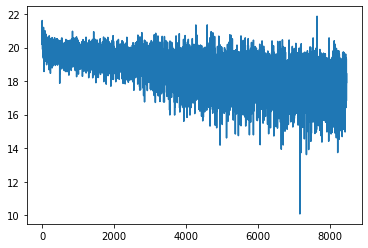

In [17]:
plt.plot(torch.arange(len(history)), history)

Files already downloaded and verified
0.2791041433811188
1
0.1584211140871048
1
0.6633641123771667
1
0.01980496011674404
0
0.401429682970047
0
-0.05259941518306732
0


'end'

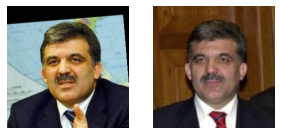

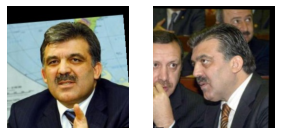

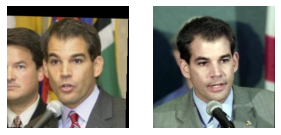

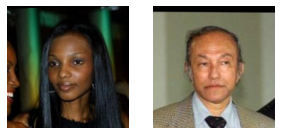

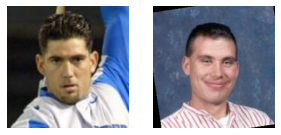

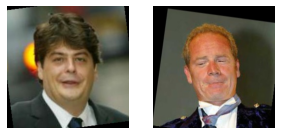

In [22]:
images = LFWPairs("ваш путь к pairs", split="test")
tt = transforms.ToTensor()
model.eval()
for i in [0, 1, 10, 511, 520, 700]:
  x1, x2, y = images[i]

  plt.figure(figsize=(10,10))

  plt.subplot(141)
  plt.axis('off')
  plt.imshow(x1)

  plt.subplot(142)
  plt.axis('off')
  plt.imshow(x2)

  x1 = tt(x1)
  x2 = tt(x2)
  h1 = model(x1.to(device).view(1, 3, 250, 250))
  h2 = model(x2.to(device).view(1, 3, 250, 250))
  h = nn.functional.cosine_similarity(h1, h2)
  
  print(h.item()), print(y)
model.train()
"end"